**Importing modules**

In [9]:
import numpy as np
import pandas as pd

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import RandomizedSearchCV

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as clr

import seaborn as sns

**Setup Matplotlib**

In [6]:
%matplotlib inline
plt.rcParams["font.family"]="Times New Roman"
plt.rcParams["font.size"]=12

colors=[(0,0.37,0.63), (0.863, 0.078, 0.235), (1, 0.84, 0)]
n_bins=3
cmap_name='my_list'
cmap=clr.LinearSegmentedColormap.from_list(cmap_name,colors,N=n_bins)

**Loading Data**

In [ ]:
data=pd.read_csv("data/adiabatic_1000_sk54.csv")
X=data[['T_0','X_fu']]
y=data['Label']
T_ad_K=data['T_ad_K']
CH2O=data['CH2O']


We plot the temperature and formaldehyde, which defines the low and high temperature ignition behavior in the 3 three classes (low T, high T, no ignition)

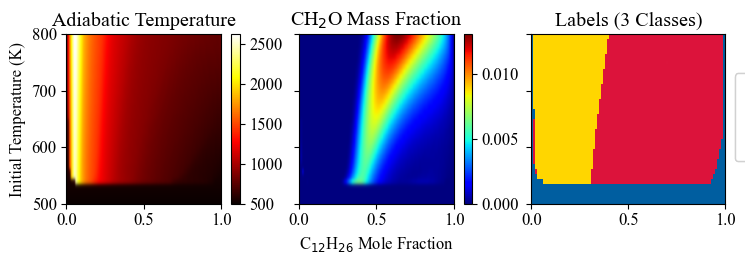

In [12]:
fig, axs= plt.subplots(1,3,figsize=(8.5,2.2),sharey=True)
image=axs[0].imshow(np.flipud(np.array(T_ad_K).reshape(34,100)),extent=[0,1,500,800],aspect='auto',interpolation='gaussian',cmap='hot')
axs[0].set_title('Adiabatic Temperature')
axs[0].set_ylabel('Initial Temperature (K)')
fig.colorbar(image, ax=axs[0])

image=axs[1].imshow(np.flipud(np.array(CH2O).reshape(34,100)),extent=[0,1,500,800]
           ,aspect='auto',interpolation = 'gaussian',cmap = 'jet')
axs[1].set_title(r'CH$_2$O Mass Fraction')
axs[1].set_xlabel(r"C$_{12}$H$_{26}$ Mole Fraction")
fig.colorbar(image, ax=axs[1])

axs[2].imshow(np.flipud(np.array(y).reshape(34,100)),extent=[0,1,500,800]
           ,aspect='auto',interpolation = 'none',cmap = cmap)
axs[2].set_title('Labels (3 Classes)')

my_scatter = axs[2].scatter([0,0.7,0.2],[500,750,750],c=[0,1,2],cmap=cmap,marker='.',s=12)
legend1 = axs[2].legend(*(my_scatter.legend_elements()[0],["No Ignition",r"Low $T$ Ignition",r"High $T$ Ignition"]),
                    loc=(1.05,0.25),ncol = 1,columnspacing=-0.2)
axs[2].add_artist(legend1)

**Train and Validation**

In [13]:
seed=42 #Initialize seed for random components in ML algorithms
X_train, X_test_dev, y_train, y_test_dev = train_test_split(X, y, test_size=0.4, random_state=seed,stratify=y)
X_dev,X_test,y_dev,y_test=train_test_split(X_test_dev,y_test_dev,test_size=0.5,random_state=seed,stratify=y_test_dev)


Train=60.0 Dev=20.0 Test=20.0


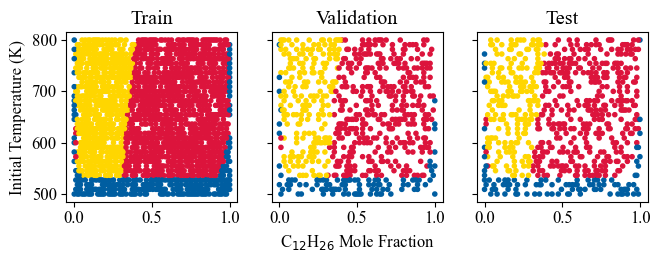

In [15]:
fig, axs = plt.subplots(1, 3, figsize=(7.5, 2.2), sharey=True)

axs[0].scatter(X_train.X_fu, X_train.T_0, c=y_train, cmap=cmap, marker='.')
axs[0].set_ylabel('Initial Temperature (K)')
axs[0].set_title('Train')

axs[1].scatter(X_dev.X_fu, X_dev.T_0, c=y_dev, cmap=cmap, marker='.')
axs[1].set_xlabel(r"C$_{12}$H$_{26}$ Mole Fraction")
axs[1].set_title('Validation')

axs[2].scatter(X_test.X_fu, X_test.T_0, c=y_test, cmap=cmap, marker='.')
axs[2].set_title('Test')

print("Train=" + str(len(y_train)/len(y)*100)+" Dev="+str(len(y_dev)/len(y)*100)+ " Test="+str(len(y_test)/len(y)*100))


The training set here will be used to fit the model. The test set will used to ensure that the trained model performs well on unseen data. The validation set acts as a test set in hyperparameter tuning.

We first normalize the dataset with a preprocessing function. This makes training easier for certain ML algortihms during gradient descent as all dimensions of the optimization manifold will be around the same scales.

In [16]:
X_train_scaled=preprocessing.StandardScaler().fit_transform(X_train)
X_dev_scaled=preprocessing.StandardScaler().fit_transform(X_dev)
X_test_scaled=preprocessing.StandardScaler().fit_transform(X_test)
X_decision_boundary=preprocessing.StandardScaler().fit_transform(X)

We use the accuracy score as performance metric to ensure that our hyperparameters of our ML model is tuned.

In [18]:
C_range=[1e-2,1e-1,1,10,1e2,1e3,1e4]
best_acc=-1
best_C=0
best_logReg=None
for C in C_range:
    logReg=LogisticRegression(C=C,random_state=seed).fit(X_train_scaled,y_train)
    y_train_pred=logReg.predict(X_train_scaled)
    y_dev_pred=logReg.predict(X_dev_scaled)
    train_acc=metrics.accuracy_score(y_train,y_train_pred)
    dev_acc=metrics.accuracy_score(y_dev,y_dev_pred)
    if dev_acc > best_acc:
        best_acc=dev_acc
        best_C=C
        best_logReg=logReg
print("The best C is %0.2f with an accuracy score of %0.5f"
      % (best_C, best_acc))

The best C is 1.00 with an accuracy score of 0.89265


In [21]:
y_test_pred=best_logReg.predict(X_test_scaled)
test_acc=metrics.accuracy_score(y_test,y_test_pred)
print("The test accuracy is ", test_acc)

The test accuracy is  0.8926470588235295
